# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that we will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

import random

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True)

In [3]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

You can here define your model that will be used for the Active learning process:

In [133]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        h = x.view(-1, 28*28)
        output = self.fc1(h)
        
        return output
    
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,2,5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(2 * 6 * 6, 10)
        
    def forward(self,x):
        x = self.pool(self.pool(F.relu(self.conv1(x))))
        x = x.view(-1, 2 * 6 * 6)
        x = self.fc1(x)
        return x

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [106]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 20

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 100
batch_size = 32

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

In [113]:
def fancy_strategy(model, dataset, nb_request=10, mode='entropy'):
    
    if mode=='random':
        N = len(dataset)
        return torch.randint(0, N, (100,))
    
    # implement your strategies as new functions here
    unlabelled_idx = dataset.tensors[1] < 0
    selected_indexes = torch.nonzero(unlabelled_idx).flatten()
    filtered_dataset = TensorDataset(*list(t[unlabelled_idx] for t in dataset.tensors))
    unlabelled_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=False)
    
    values = torch.zeros(len(filtered_dataset))#unlabelled_idx))
    with torch.no_grad():
        for bth_idx, (data, _) in enumerate(unlabelled_loader):
            try:
                prediction = model(data) # in this case, the linear model doesn't require a reshape
            except:
                prediction = model(data.reshape(-1,1,28,28)) # the convolution operation requires to reshape
            prediction = nn.Softmax(dim=-1)(prediction) # get the prediction socres as a probability
            if mode=='uncertainty':
                best_pred, _ = torch.topk(prediction, 1) # Consider the highest probability for each sample 
                update = - best_pred[:,0]# and select the lowest ones (highest inversed ones)
            elif mode=='entropy':
                update = - torch.sum((prediction * torch.log(prediction)), axis=1)
            elif mode=='deviation':
                best_pred, _ = torch.topk(prediction, 2) # get the two best scores
                update = - torch.abs(best_pred[:,0] - best_pred[:,1]) # compute the difference between those two
                # we want to take the indexes which minimize the deviation so which maximize its opposite (topk)
            else:
                # Could be interesting to get the samples supposed to change the most the global predictions
                RuntimeError('Error: mode not recognized')
                
            values[bth_idx*batch_size: bth_idx*batch_size+len(prediction)] = update
            
    _, indices = torch.topk(values, nb_request)
    
    return selected_indexes[indices]

This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [129]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, model=Model, retrain=False, dataset=None, initial_labeling=20, nb_request=10):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                try:
                    prediction = model(data)
                except:
                    prediction = model(data.reshape(-1,1,28,28))
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                try:
                    prediction = model(data)
                except:
                    prediction = model(data.reshape(-1,1,28,28))
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    if not retrain:
        model = model() # Model()
    else:
        loaded = False
    local_lr = learning_rate
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        # create a new model to train on this dataset
        if retrain and not loaded:
            model = model()
            loaded = True
        else:
            # if we don't retrain, then we need to decrease the learning rate with the training
            if i%5==4:
                local_lr = local_lr/10
        # OPTIMIZER
        optimizer = torch.optim.SGD(model.parameters(), lr=local_lr)
        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: Loss = {:.4f} -- Val_Acc = {:.2f}%".format(len(filtered_dataset),
                                                                                           valid_loss, 
                                                                                           valid_acc*100))
        
        if i < num_active_runs:
            to_label = fancy_strategy(model, dataset, nb_request, mode=strategy)
            call_expert(dataset, to_label)
    
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

In [122]:
# a list of strategies you want to compare
strategies = ['uncertainty','deviation','entropy']
# number of examples to label randomly at the start
initial_labeling = 100
nb_request=10

performances = []
for strat in strategies:
    print("Training with strategy: {}".format(strat))#.__name__))
    perf = active_training(strat, model=Model, retrain=False,
                           initial_labeling=initial_labeling, nb_request=nb_request)
    performances.append((strat, perf))#.__name__, perf))
print("done")

Training with strategy: uncertainty
With 100 examples, valid perf is: Loss = 0.9211 -- Val_Acc = 72.88%
With 110 examples, valid perf is: Loss = 0.9407 -- Val_Acc = 73.56%
With 120 examples, valid perf is: Loss = 0.8504 -- Val_Acc = 75.40%
With 130 examples, valid perf is: Loss = 0.9970 -- Val_Acc = 74.38%
With 140 examples, valid perf is: Loss = 0.7588 -- Val_Acc = 78.76%
With 150 examples, valid perf is: Loss = 0.7641 -- Val_Acc = 78.68%
With 160 examples, valid perf is: Loss = 0.7818 -- Val_Acc = 78.12%
With 170 examples, valid perf is: Loss = 0.7161 -- Val_Acc = 80.14%
With 180 examples, valid perf is: Loss = 0.6871 -- Val_Acc = 81.00%
With 190 examples, valid perf is: Loss = 0.6849 -- Val_Acc = 81.02%
With 200 examples, valid perf is: Loss = 0.6805 -- Val_Acc = 81.10%
With 210 examples, valid perf is: Loss = 0.6812 -- Val_Acc = 81.18%
With 220 examples, valid perf is: Loss = 0.6856 -- Val_Acc = 81.14%
With 230 examples, valid perf is: Loss = 0.6921 -- Val_Acc = 80.94%
With 240 exa

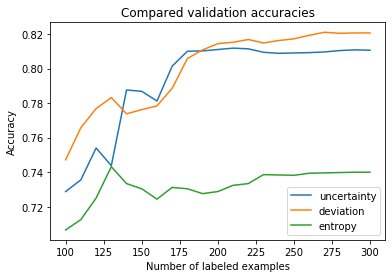

In [123]:
plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

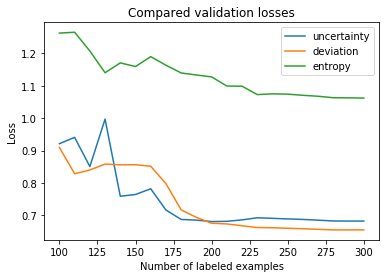

In [124]:
plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

---
**What if we retrain the model from scratch at each step ?**

In [130]:
# a list of strategies you want to compare
strategies = ['uncertainty','deviation','entropy']
# number of examples to label randomly at the start
initial_labeling = 100
nb_request=10

performances = []
for strat in strategies:
    print("Training with strategy: {}".format(strat))#.__name__))
    perf = active_training(strat, model=Model, retrain=True,
                           initial_labeling=initial_labeling, nb_request=nb_request)
    performances.append((strat, perf))#.__name__, perf))
print("done")

Training with strategy: uncertainty
With 100 examples, valid perf is: Loss = 0.8928 -- Val_Acc = 75.28%
With 110 examples, valid perf is: Loss = 0.7987 -- Val_Acc = 77.06%
With 120 examples, valid perf is: Loss = 0.7385 -- Val_Acc = 79.42%
With 130 examples, valid perf is: Loss = 0.7787 -- Val_Acc = 79.06%
With 140 examples, valid perf is: Loss = 0.8009 -- Val_Acc = 78.50%
With 150 examples, valid perf is: Loss = 0.8165 -- Val_Acc = 78.18%
With 160 examples, valid perf is: Loss = 0.7918 -- Val_Acc = 78.88%
With 170 examples, valid perf is: Loss = 0.7556 -- Val_Acc = 79.82%
With 180 examples, valid perf is: Loss = 0.7111 -- Val_Acc = 80.92%
With 190 examples, valid perf is: Loss = 0.7132 -- Val_Acc = 80.88%
With 200 examples, valid perf is: Loss = 0.7066 -- Val_Acc = 80.92%
With 210 examples, valid perf is: Loss = 0.7003 -- Val_Acc = 81.08%
With 220 examples, valid perf is: Loss = 0.6983 -- Val_Acc = 80.82%
With 230 examples, valid perf is: Loss = 0.6912 -- Val_Acc = 81.18%
With 240 exa

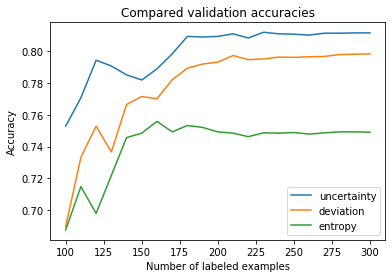

In [131]:
plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

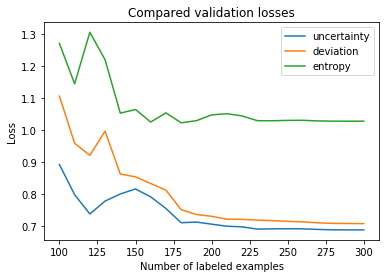

In [132]:
plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**To present in the report :**
 - **Impact of the strategy**
 - **Impact of the network (using a convolution works impressively well) : for instance, how many examples are required to reach a certain performance (nb_added_samples, nb_epochs)...**
 - **Impact of retraining the model from scratch or not**
 - **...**

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**